In this code, all the methods were tested to reconstruct dark purple.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
!pip install GPyOpt
!pip install pyDOE
import GPyOpt
from pyDOE import lhs
!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=8f1636bb6f1eceef8c726a13bc98ed3ec1c6253d7d30c9ca7e9dc5fffd0e87db
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420165 sha256=dbaa9f2472570f19f403b47f2dd8dbe7a24ab774190258d36c2b32f412cf1ef3
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102544 sha256=a0de6f55e6b6e73696ed6793a

In [ ]:
#xyz bar
xyzbar = np.array(pd.read_excel('XYZ.xlsx',usecols='C:E'))
E = np.array(pd.read_excel('XYZ.xlsx',usecols='B'))

#Reflectances
data = np.array(pd.read_excel('clean-data-10nm.xlsx', usecols='A:J'))

wavelength = data[:,0]

white = data[:,1]
red_petg = data[:,2]
black = data[:,4]
dark_purple = data[:,5] #light purple
gray = data[:,6]
blue_pla = data[:,7]
cream = data[:,8]
Slime_green = data[:,9]


#purple PET-G
target = data[:,3]


In [ ]:
def xyz(E, xbar, ybar, zbar, R):

  E = np.array(E)
  xbar = np.array(xbar)
  ybar = np.array(ybar)
  zbar = np.array(zbar)
  R = np.array(R)

  K = 100 / sum(E * ybar)
  Xn = K * sum(E * xbar)
  Yn = K * sum(E * ybar)
  Zn = K * sum(E * zbar)
  X = K * sum(E * xbar * R)
  Y = K * sum(E * ybar * R)
  Z = K * sum(E * zbar * R)
  L = 116 * (abs(Y / Yn) ** (1 / 3)) - 16
  a = 500 * (abs(X / Xn) * (1 / 3) - abs(Y / Yn) * (1 / 3))
  b = np.where(np.abs(Y / Yn) < 1e-10, 0, 200 * (np.abs(Y / Yn) ** (1 / 3) - np.abs(Z / Zn) ** (1 / 3)))
  XYZ = [X, Y, Z]
  lab = [L, a, b]
  return lab

In [ ]:
def objective(proportions):

    proportions = (proportions.reshape(5, 1))

    predicted_color = (proportions[0] * white +
                       proportions[1] * red_petg +
                       proportions[2] * dark_purple +
                       proportions[3] * black +
                       proportions[4] * blue_pla)

    #shape = predicted_color.shape
    #print(shape)

    # RMS Error
    lse_error = np.sqrt(np.mean((predicted_color - target) ** 2))

    # ΔE Error
    target_lab = xyz(E, xyzbar[:,0],xyzbar[:,1],xyzbar[:,2],target)
    L_target, a_target, b_target = target_lab

    predicted_lab = xyz(E, xyzbar[:,0],xyzbar[:,1],xyzbar[:,2],predicted_color)
    L_predict, a_predict, b_predict = predicted_lab

    delta_e = (sum((np.array(predicted_lab).real - np.array(target_lab).real) ** 2)) ** (0.5)
    delta_e = np.nan_to_num(delta_e, nan=0)
    delta_e_mean=(np.mean(delta_e))


    # Combine the two error metrics as needed
    combined_objective = 0.9 * lse_error + 0.1 * delta_e_mean


    return combined_objective


In [ ]:
def predictedSpectrum (estimation):

  predicted_spectrum = (estimation[0] * white +
                      estimation[1] * red_petg +
                      estimation[2] * dark_purple +
                      estimation[3] * black +
                      estimation[4] * blue_pla)
  return predicted_spectrum


In [ ]:
def errors(pred_spec):
  rms = np.sqrt(np.mean((pred_spec - target)**2))

  target_lab = xyz(E, xyzbar[:,0],xyzbar[:,1],xyzbar[:,2],target)
  L_target, a_target, b_target = target_lab

  predicted_lab = xyz(E, xyzbar[:,0],xyzbar[:,1],xyzbar[:,2],pred_spec)
  L_predict, a_predict, b_predict = predicted_lab

  delta_e =  (sum((np.array(predicted_lab).real - np.array(target_lab).real) ** 2)) ** (0.5)
  delta_e = np.nan_to_num(delta_e, nan=0)

  result = print(f'RMS = {np.round(rms,4)}\ndelta E = {np.round(np.mean(delta_e),4)}')

  return result


In [ ]:
bounds = [{'name': 'proportion_1', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'proportion_2', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'proportion_3', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'proportion_4', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'proportion_5', 'type': 'continuous', 'domain': (0, 1)}]

domain_values = [bound['domain'] for bound in bounds]
print(np.shape(domain_values))
# Convert the list of domain values into a NumPy array with shape (5, 1)
#array_bounds = np.array(domain_values).reshape(5, 1)
print(domain_values)

(5, 2)
[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]


In [ ]:
initial_design_numdata = 5 # Number of initial data points
initial_data = lhs(len(bounds), samples=initial_design_numdata)
#print(f'Initial data =\n {initial_data}')


problem = GPyOpt.methods.BayesianOptimization(
    f= objective,
    domain= bounds,
    X=initial_data,  # Number of initial data points
    acquisition_type='EI',    # Expected Improvement
    acquisition_optimizer='CMA',
    maximize= False            # Set to True if maximizing the objective function
)
max_iter = 250
problem.run_optimization(max_iter=max_iter)

# Estimated proportions
estimated= problem.x_opt
estimated_value = problem.fx_opt

In [ ]:
# Print the estimated proportions
print(f'Estimated Proportions:\n {estimated}')
predicted_spectrum_0 = predictedSpectrum(estimated)
evaluation = errors(predicted_spectrum_0)

Estimated Proportions:
 [0.         0.14252506 0.         0.         0.7909381 ]
RMS = 0.022
delta E = 0.7849


Optimization GPyOpt

In [ ]:
initial_design_numdata = 5 # Number of initial data points
initial_data = lhs(len(bounds), samples=initial_design_numdata)
#print(f'Initial data =\n {initial_data}')


problem1 = GPyOpt.methods.BayesianOptimization(
    f= objective,
    domain= bounds,
    X=initial_data,  # Number of initial data points
    acquisition_type='EI',    # Expected Improvement
    acquisition_optimizer='lbfgs',
    maximize= False            # Set to True if maximizing the objective function
)
max_iter = 250
problem1.run_optimization(max_iter=max_iter)

# Estimated proportions
estimated1= problem1.x_opt
estimated_value1 = problem1.fx_opt

Errors

In [ ]:
# Print the estimated proportions
print(f'Estimated Proportions1: {estimated1}')
predicted_spectrum_1 = predictedSpectrum(estimated1)
evaluation = errors(predicted_spectrum_1)

Estimated Proportions1: [0.         0.15308245 0.         0.         0.78823816]
RMS = 0.021
delta E = 0.7862


In [ ]:
initial_design_numdata = 5 # Number of initial data points
initial_data = lhs(len(bounds), samples=initial_design_numdata)
#print(f'Initial data =\n {initial_data}')


problem2 = GPyOpt.methods.BayesianOptimization(
    f= objective,
    domain= bounds,
    X=initial_data,  # Number of initial data points
    acquisition_type='MPI',    # Expected Improvement
    acquisition_optimizer='CMA',
    maximize= False            # Set to True if maximizing the objective function
)
max_iter = 250
problem2.run_optimization(max_iter=max_iter)

# Estimated proportions
estimated2= problem2.x_opt
estimated_value2 = problem2.fx_opt

Errors

In [ ]:
# Print the estimated proportions
print(f'Estimated Proportions: {estimated2}')
predicted_spectrum_2 = predictedSpectrum(estimated2)
evaluation = errors(predicted_spectrum_2)

Estimated Proportions: [0.         0.1488995  0.         0.         0.81534032]
RMS = 0.019
delta E = 0.8144


In [ ]:
initial_design_numdata = 5 # Number of initial data points
initial_data = lhs(len(bounds), samples=initial_design_numdata)
#print(f'Initial data =\n {initial_data}')


problem3 = GPyOpt.methods.BayesianOptimization(
    f= objective,
    domain= bounds,
    X=initial_data,  # Number of initial data points
    acquisition_type='MPI',    # Expected Improvement
    acquisition_optimizer='lbfgs',
    maximize= False            # Set to True if maximizing the objective function
)
max_iter = 250
problem3.run_optimization(max_iter=max_iter)

# Estimated proportions
estimated3= problem3.x_opt
estimated_value3 = problem3.fx_opt

In [ ]:
# Print the estimated proportions
print(f'Estimated Proportions: {estimated3}')
predicted_spectrum_3 = predictedSpectrum(estimated3)
evaluation3 = errors(predicted_spectrum_3)

Estimated Proportions: [0.         0.14411228 0.         0.         0.83484129]
RMS = 0.0197
delta E = 0.8833


**SciKit Optimize**

In [ ]:
def objective(proportions):


  predicted_color = (proportions[0] * white +
                       proportions[1] * red_petg +
                       proportions[2] * dark_purple +
                       proportions[3] * black +
                       proportions[4] * blue_pla)

  # RMS Error
  lse_error = np.sqrt(np.mean((predicted_color - target) ** 2))

  # ΔE Error
  target_lab = xyz(E, xyzbar[:,0],xyzbar[:,1],xyzbar[:,2],target)
  L_target, a_target, b_target = target_lab

  predicted_lab = xyz(E, xyzbar[:,0],xyzbar[:,1],xyzbar[:,2],predicted_color)
  L_predict, a_predict, b_predict = predicted_lab

  delta_e = (sum((np.array(predicted_lab).real - np.array(target_lab).real) ** 2)) ** (0.5)
  delta_e = np.nan_to_num(delta_e, nan=0)
  delta_e_mean=(np.mean(delta_e))


  # Combine the two error metrics as needed
  combined_objective = 0.9 * lse_error + 0.1 * delta_e_mean


  return combined_objective



space = [Real(0,1, name='prop1'), Real(0,1, name='prop2'), Real(0,1, name='prop3'),
         Real(0,1, name='prop4'), Real(0,1, name='prop5')]

guess = [0.12, 0.25 ,0.09, 0.04, 0.5]

result4 = gp_minimize(
    objective,
    space,
    x0= guess,
    n_calls = 250,
    random_state = 42
)

estimated4 = result4.x
print(estimated4)


# Print the estimated proportions
print(f'Estimated Proportions: {estimated4}')
predicted_spectrum_4 = predictedSpectrum(estimated4)
evaluation4 = errors(predicted_spectrum_4)

[0.0, 0.15073733753673932, 0.0, 0.0, 0.7923886279331769]
Estimated Proportions: [0.0, 0.15073733753673932, 0.0, 0.0, 0.7923886279331769]
RMS = 0.0206
delta E = 0.7845


**SciPy methods**

In [ ]:
from scipy.optimize import minimize

bounds = [(0,1)]*5
result5 = minimize(objective,guess,bounds= bounds, method='L-BFGS-B')
estimated5 = result5.x


# Print the estimated proportions
print(f'Estimated Proportions: {estimated5}')
predicted_spectrum_5 = predictedSpectrum(estimated5)
evaluation5 = errors(predicted_spectrum_5)

Estimated Proportions: [0.         0.15332428 0.         0.         0.79073339]
RMS = 0.0206
delta E = 0.7842


In [ ]:
result6 = minimize(objective,guess,bounds= bounds, method='SLSQP')
estimated6 = result6.x


# Print the estimated proportions
print(f'Estimated Proportions:\n {estimated6}')
predicted_spectrum_6 = predictedSpectrum(estimated6)
evaluation6 = errors(predicted_spectrum_6)

Estimated Proportions:
 [9.45180644e-18 1.50957010e-01 3.94896429e-03 8.66447014e-18
 7.89609869e-01]
RMS = 0.0206
delta E = 0.7845


In [ ]:
result7 = minimize(objective,guess,bounds= bounds, method='Nelder-Mead')
estimated7 = result7.x
print(estimated7)


# Print the estimated proportions
print(f'Estimated Proportions: {estimated7}')
predicted_spectrum_7 = predictedSpectrum(estimated7)
evaluation7 = errors(predicted_spectrum_7)

[0.00467902 0.13508092 0.04877429 0.0287748  0.75151052]
Estimated Proportions: [0.00467902 0.13508092 0.04877429 0.0287748  0.75151052]
RMS = 0.021
delta E = 0.8326


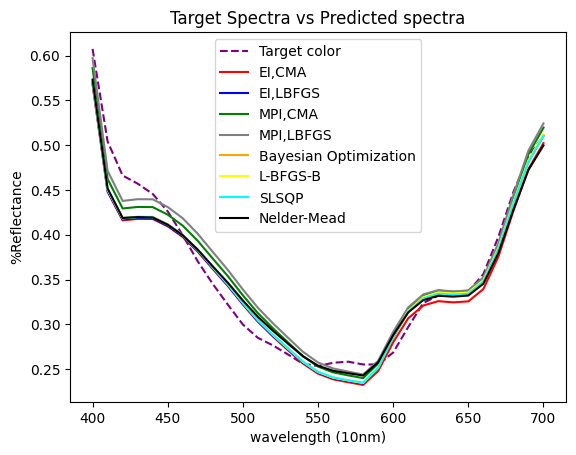

In [ ]:
x = wavelength
plt.plot(x, target, 'purple', label='Target color',linestyle='--', markersize='7')  # purple
plt.plot(x, predicted_spectrum_0, 'r', label='EI,CMA', markersize='7')
plt.plot(x, predicted_spectrum_1, 'b', label='EI,LBFGS', markersize='7')
plt.plot(x, predicted_spectrum_2, 'g', label='MPI,CMA', markersize='7')
plt.plot(x, predicted_spectrum_3, 'gray', label='MPI,LBFGS', markersize='7')
plt.plot(x, predicted_spectrum_4, 'orange', label='Bayesian Optimization', markersize='7')
plt.plot(x, predicted_spectrum_5, 'yellow', label='L-BFGS-B', markersize='7')
plt.plot(x, predicted_spectrum_6, 'cyan', label='SLSQP', markersize='7')
plt.plot(x, predicted_spectrum_7, 'k', label='Nelder-Mead', markersize='7')   # predicted
plt.xlabel('wavelength (10nm)')
plt.ylabel('%Reflectance')
plt.title('Target Spectra vs Predicted spectra')
plt.legend(loc='best')
plt.grid(False )
plt.show()